# Gaussian Shells

A modification on https://num.pyro.ai/en/latest/examples/gaussian_shells.html, a distribution we can calculate the true evidence for.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpyro
import numpyro.distributions as dist
import numpyro.infer.util

import jax
import jax.numpy as jnp
import jax.flatten_util

import optax

import matplotlib.pyplot as plt
import arviz as az

from CT_HMC_wrappers import (
    wrap_model,
    re_center_guide,
    nlogZ,
    get_value_from_index
)
from corner import corner

numpyro.set_host_device_count(4)

## Define the dist

We will use a `Mixture` to mix two of these `GaussianShell` distributions together.  As `Mixture` will re-normalize the result we will add in a factor of `2` to each shell so the result is the same has just multiplying the two base distributions.

In [3]:
class GaussainShell(dist.Distribution):
    support = dist.constraints.real_vector

    def __init__(self, loc, radius, width):
        self.loc, self.radius, self.width = loc, radius, width
        super().__init__(batch_shape=loc.shape[:-1], event_shape=loc.shape[-1:])

    def sample(self, key, sample_shape=()):
        return jnp.zeros(
            sample_shape + self.shape()
        )  # a dummy sample to initialize the samplers

    def log_prob(self, value):
        # add jnp.log(2) so it is un-normalized after mixing two of them
        normalizer =  -0.5 * jnp.log(2.0 * jnp.pi) - jnp.log(self.width) + jnp.log(2)
        d = jnp.linalg.norm(value - self.loc, axis=-1)
        return normalizer - 0.5 * ((d - self.radius) / self.width) ** 2

## Evaluate on a grid

This is simple enough we can evaluation the full distribution on a grid and use that to estimate the evidence (assuming a uniform prior over the full grid).

In [4]:
probs = jnp.array([0.5, 0.5])

mixing_dist = dist.Categorical(probs=probs)
D = dist.Mixture(
    mixing_dist,
    [
        GaussainShell(loc=jnp.array([0.0, -3.5]), radius=2.0, width=0.1),
        GaussainShell(loc=jnp.array([0.0, 3.5]), radius=2.0, width=0.1),
    ]
)

True log(Z): -1.7456541061401367


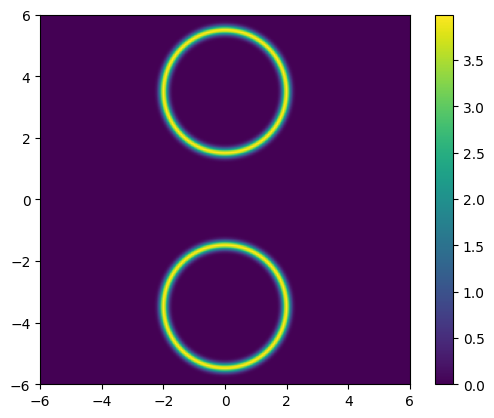

In [5]:
u_vec = jnp.linspace(-6., 6., 250)
xx, yy = jnp.meshgrid(u_vec, u_vec)
args = jnp.dstack((xx, yy))

log_prob = D.log_prob(args)

log_Z_true = (
    jax.lax.reduce(log_prob, -1e25, jnp.logaddexp, (0, 1)) # sum pixel values
    + 2 * jnp.log(u_vec[1] - u_vec[0]) # area of one pixel
    - 2 * jnp.log(12) # uniform prior
)

print(f'True log(Z): {log_Z_true}')

plt.imshow(
    jnp.exp(log_prob),
    extent=(u_vec.min(), u_vec.max(), u_vec.min(), u_vec.max())
)
plt.colorbar();

## The model

In [6]:
def model(center1, center2, radius, width):
    x = numpyro.sample('x', dist.Uniform(-6.0, 6.0).expand([2]).to_event(1))
    numpyro.sample(
        'shell',
        dist.Mixture(
            mixing_dist,
            [
                GaussainShell(loc=center1, radius=radius, width=width),
                GaussainShell(loc=center2, radius=radius, width=width),
            ]
        ), 
        obs=x
    )


args = (
    jnp.array([0.0, -3.5]),
    jnp.array([0.0, 3.5]),
    2.0,
    0.1
)

In [7]:
rng_key = jax.random.PRNGKey(0)

## NUTS on its own

How well does standard NUTS handel this distribution?

In [8]:
nuts_key, rng_key = jax.random.split(rng_key, 2)

In [9]:
num_chains = 4

nuts_kernel = numpyro.infer.NUTS(model, target_accept_prob=0.9, dense_mass=True)
mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    num_warmup=1000,
    num_samples=5000,
    num_chains=num_chains,
    chain_method='parallel',
    progress_bar=True,
)
mcmc.run(nuts_key, *args)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

[0 0 0 0]


/Users/coleman/anaconda3/envs/lensing/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x[0],0.036,1.427,-2.039,2.029,0.027,0.019,3050.0,8765.0,1.00
x[1],-1.734,3.389,-5.639,5.074,1.551,1.172,7.0,31.0,1.53


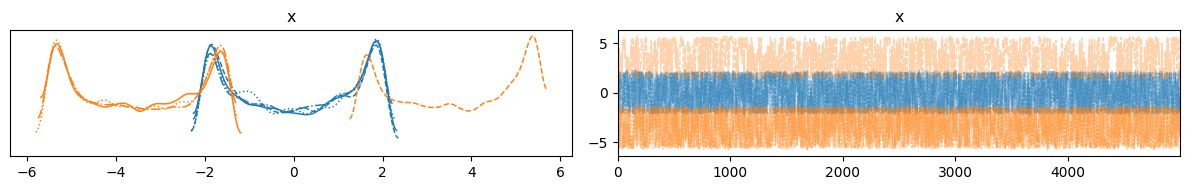

In [10]:
inf_nuts = az.from_numpyro(mcmc)

print(inf_nuts.sample_stats.diverging.data.sum(axis=1))
display(az.summary(inf_nuts))
az.plot_trace(inf_nuts)
plt.tight_layout();

We see that different chains get stuck in different modes.  Let's make a corner plot that is colored by chain to see this more clearly.

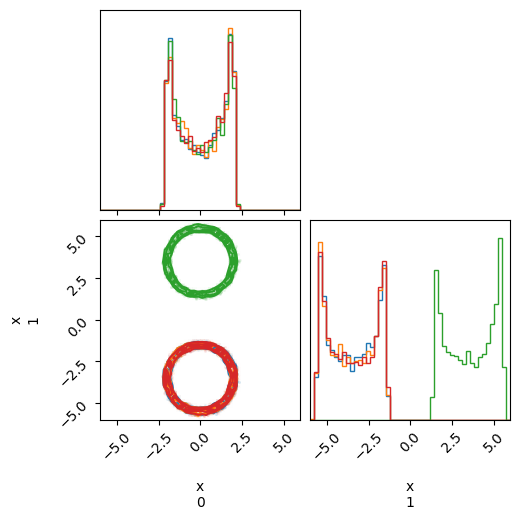

In [11]:
fig_corner = None
for i in range(num_chains):
    fig_corner = corner(
        inf_nuts.isel(chain=i),
        color=f'C{i}',
        fig=fig_corner,
        range=[(-6, 6), (-6, 6)],
        bins=50
    )

## SVI

We will do a multi-start SVI run with a `RenyiELBO` to look for a mode-covering solution.

In [12]:
svi_key, rng_key = jax.random.split(rng_key, 2)

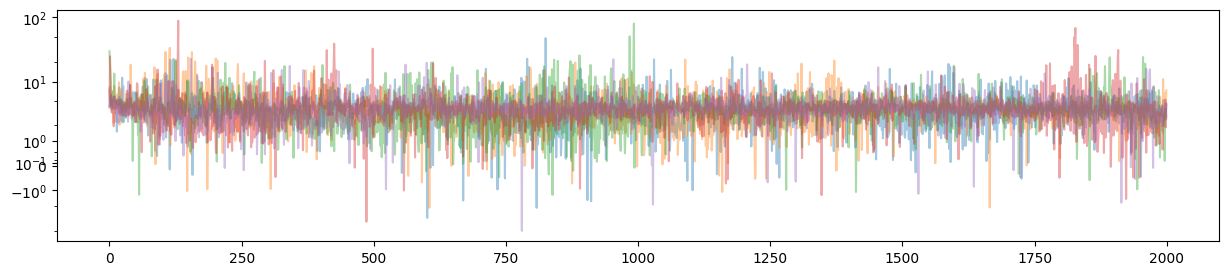

In [13]:
num_svi_runs = 5

init_fun = numpyro.infer.init_to_median()
target_guide = numpyro.infer.autoguide.AutoDiagonalNormal(model, init_loc_fn=init_fun)

scheduler1 = optax.exponential_decay(
    init_value=0.1,
    decay_rate=0.99,
    transition_steps=100
)

optim = optax.adabelief(learning_rate=scheduler1)
loss = numpyro.infer.RenyiELBO(alpha=0.1, num_particles=10)
svi = numpyro.infer.SVI(
    model,
    target_guide,
    optim,
    loss
)

@jax.vmap
def map_svi(key):
    return svi.run(
        key,
        2000,
        *args,
        progress_bar=False,
        stable_update=True
    )

svi_keys = jax.random.split(svi_key, num_svi_runs)
multi_svi_results = map_svi(svi_keys)

plt.figure(figsize=(15, 3))
plt.plot(multi_svi_results.losses.T, alpha=0.4)
plt.gca().set_yscale('asinh');

Let's draw samples from each SVI solution and treat them like chains from a sampler and make some corner plots.

In [14]:
svi_samples = target_guide.sample_posterior(rng_key, multi_svi_results.params, sample_shape=(5000,))
svi_samples_chains = jax.tree.map(lambda x: jnp.swapaxes(x, 0, 1), svi_samples)
svi_samples_chains = jax.device_get(svi_samples_chains)
multi_svi_guide_sample = az.from_dict(svi_samples_chains)

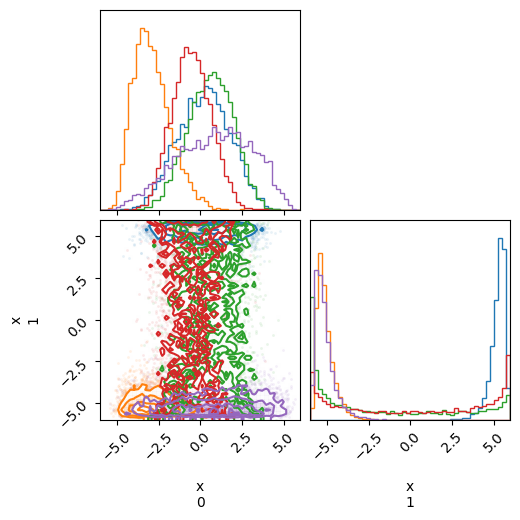

In [15]:
fig_corner = None
for i in range(num_svi_runs):
    fig_corner = corner(
        multi_svi_guide_sample.isel(chain=i),
        color=f'C{i}',
        fig=fig_corner,
        range=[(-6, 6), (-6, 6)],
        bins=50
    )

Looks like index `3` (red) is the most mode covering:

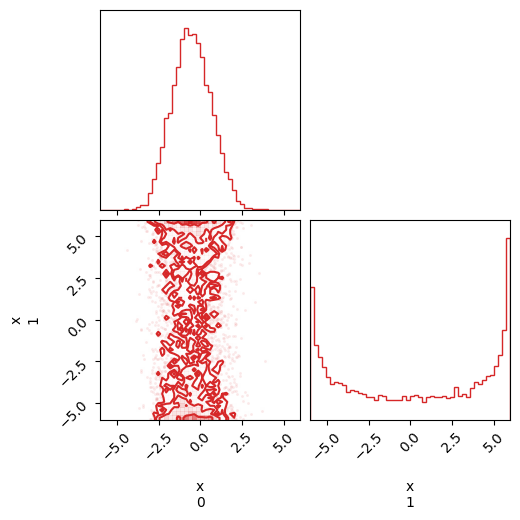

In [16]:
i=3
corner(
    multi_svi_guide_sample.isel(chain=i),
    color=f'C{i}',
    range=[(-6, 6), (-6, 6)],
    bins=50
);

## CTHMC

In [17]:
def run_inference(mcmc_key, init_key, potential_energy_fn, sample_init_fn, postprocessing_fn, svi_params):
    unconstrained_init_params = sample_init_fn(init_key, svi_params, num_chains)
    nuts_kernel = numpyro.infer.NUTS(
        potential_fn=potential_energy_fn,
        target_accept_prob=0.99,
        dense_mass=True
    )

    mcmc = numpyro.infer.MCMC(
        nuts_kernel,
        num_warmup=1000,
        num_samples=10000,
        num_chains=num_chains,
        chain_method='parallel',
        progress_bar=True,
        postprocess_fn=postprocessing_fn
    )
    mcmc.run(
        mcmc_key,
        init_params=unconstrained_init_params
    )
    return mcmc


def first_cthmc_run(svi_result, rng_key):
    # CTHMC seeded from an SVI result object
    mcmc_key, init_key, rng_key = jax.random.split(rng_key, 3)
    _, potential_energy_fn, sample_init_fn, postprocessing_fn, neg_elbo = wrap_model(
        model,
        args,
        {},
        target_guide,
        svi_result
    )

    cthmc = run_inference(
        mcmc_key,
        init_key,
        potential_energy_fn,
        sample_init_fn,
        postprocessing_fn,
        svi_result.params
    )
    return cthmc, neg_elbo, rng_key

In [18]:
cthmc, neg_elbo, rng_key = first_cthmc_run(
    get_value_from_index(multi_svi_results, 3), # SVI index 3 result
    rng_key
)

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

[0 0 0 0]


/Users/coleman/anaconda3/envs/lensing/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x[0],-0.155,1.328,-2.037,1.992,0.016,0.011,6957.0,16951.0,1.0
x[1],1.871,3.520,-5.309,5.670,1.173,0.858,13.0,53.0,1.2
inv_temp,0.761,0.229,0.283,1.000,0.002,0.002,10811.0,8614.0,1.0


Current log(Z) estimate: -1.7310738563537598
True log(Z) value: -1.7456541061401367


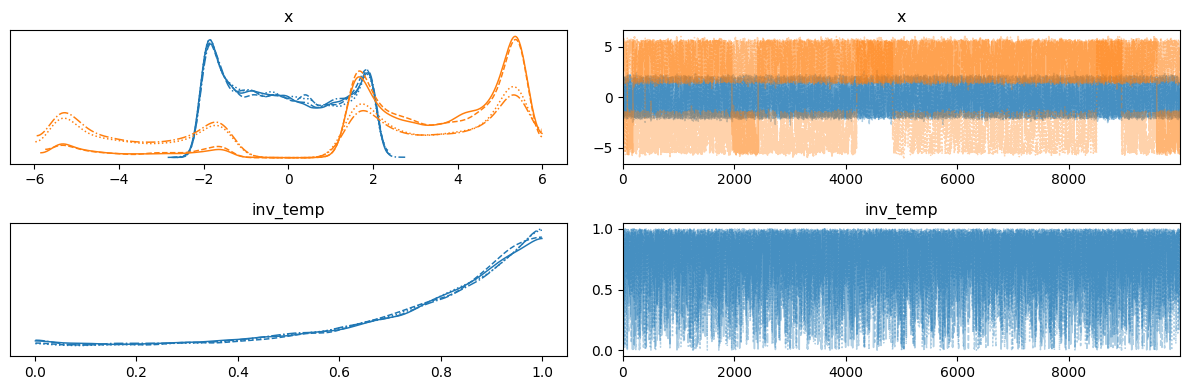

In [19]:
inf_cthmc = az.from_numpyro(cthmc)

var_names = ['x', 'inv_temp']
print(inf_cthmc.sample_stats.diverging.data.sum(axis=1))
display(az.summary(inf_cthmc, var_names=var_names))
az.plot_trace(inf_cthmc, var_names=var_names)
plt.tight_layout()

neg_log_Z = nlogZ(neg_elbo, cthmc.get_samples())
print(f'Current log(Z) estimate: {-neg_log_Z}')
print(f'True log(Z) value: {log_Z_true}')

This is much closer to converged, but the `inv_temp` is not very uniform and the `r_hat` is large for `x[1]`.  Let's look at the corner plot for each chain.

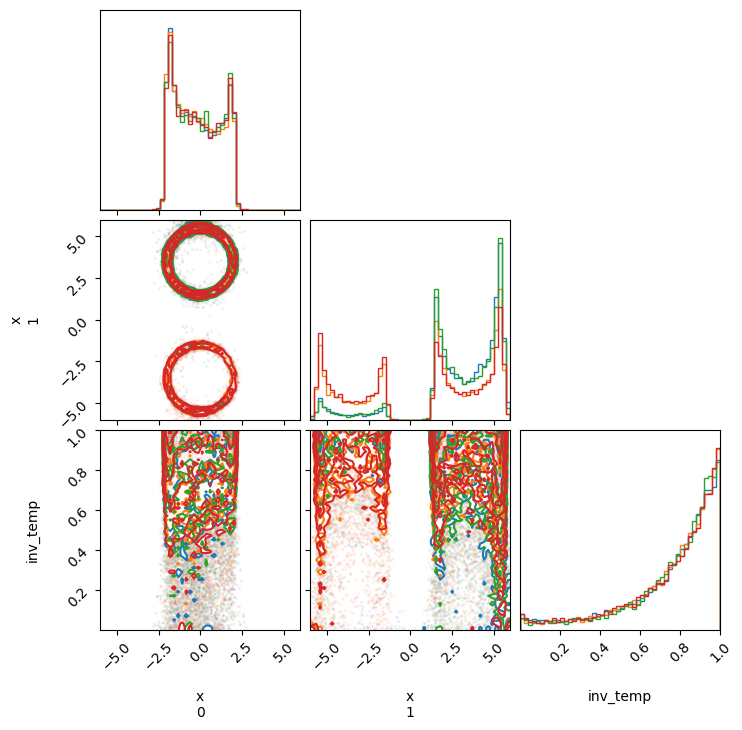

In [20]:
fig_corner = None
for i in range(num_chains):
    fig_corner = corner(
        inf_cthmc.isel(chain=i),
        color=f'C{i}',
        fig=fig_corner,
        range=[(-6, 6), (-6, 6), (0, 1)],
        bins=50,
        var_names=var_names
    )

They are for the most part identical!  Now all the chains at once.

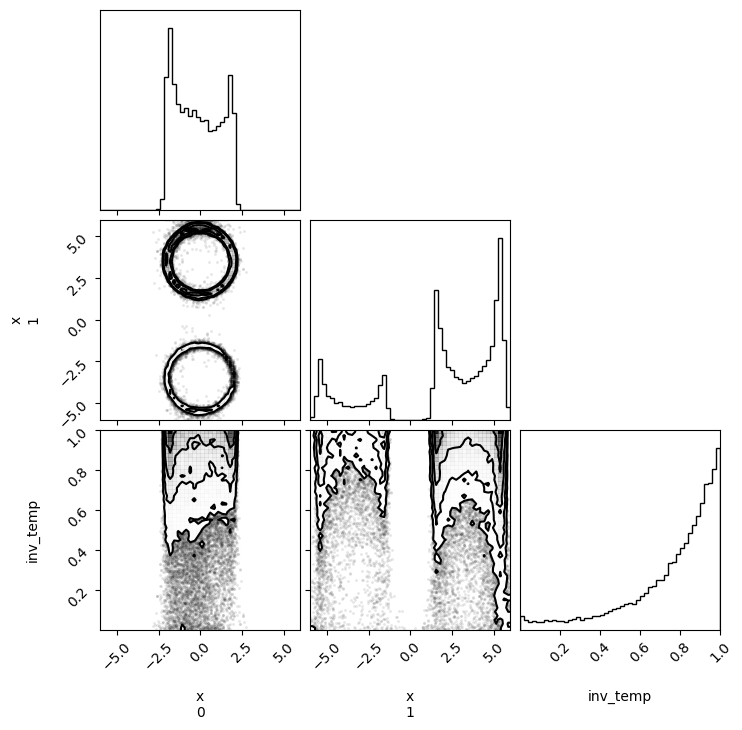

In [21]:
fig = corner(
    inf_cthmc,
    range=[(-6, 6), (-6, 6), (0, 1)],
    bins=50,
    var_names=var_names
)

## Importance sample

The corner plot looks a bit lopsided, this is because we need to use importance sampling with the weights `w1` to bring all samples into the lower temperature (`inv_temp=1`) state.  We can also weight back to the high temperature (`inv_temp=0`) state with `w0`.

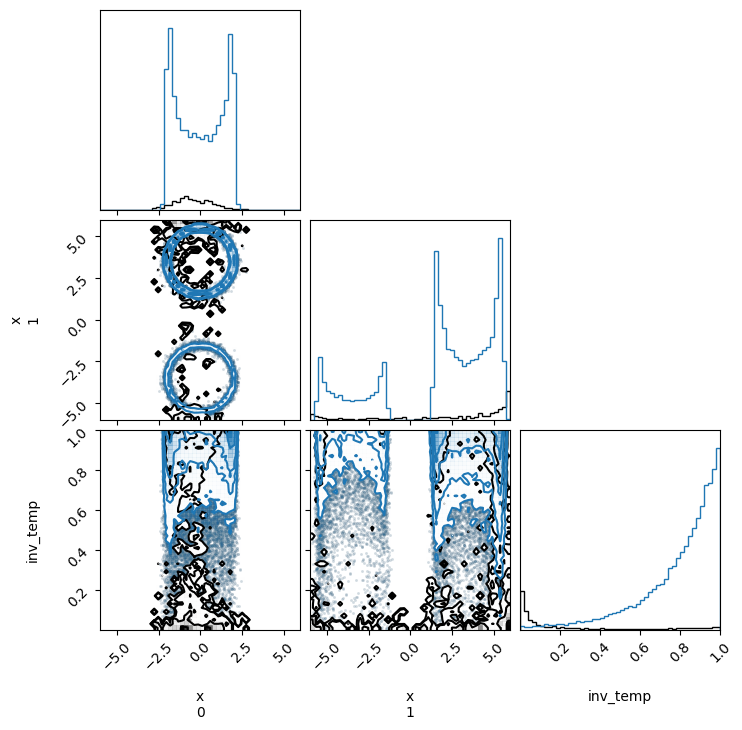

In [22]:
# flatten the weights into vectors 
w1 = inf_cthmc.posterior.w1.stack(desired=['chain', 'draw']).data
w0 = inf_cthmc.posterior.w0.stack(desired=['chain', 'draw']).data

fig = corner(
    inf_cthmc,
    range=[(-6, 6), (-6, 6), (0, 1)],
    bins=50,
    var_names=var_names,
    weights=w0,
    color='k'
)

fig = corner(
    inf_cthmc,
    range=[(-6, 6), (-6, 6), (0, 1)],
    bins=50,
    var_names=var_names,
    fig=fig,
    weights=w1,
    color='C0'
)

## Re-center and iterate

At the moment the evidence looks good, but the `inv_temp` did not have very good mixing (i.e. not close to uniform), let's try re-centring the guide on the current (weighted) samples and run the process again. 

In [23]:
print(f'Current log(Z) estimate: {-neg_log_Z}')
print(f'True log(Z) value: {log_Z_true}')

Current log(Z) estimate: -1.7310738563537598
True log(Z) value: -1.7456541061401367


As we will be running this several times, let's wrap the iteration and standard plots into some functions.

In [24]:
def iterate_cthmc(cthmc, neg_elbo, rng_key):
    iter_param, iter_neg_elbo = re_center_guide(
        model,
        args,
        {},
        cthmc,
        target_guide,
        neg_elbo
    )
    mcmc_key, init_key, rng_key = jax.random.split(rng_key, 3)
    _, potential_energy_fn, sample_init_fn, postprocessing_fn, neg_elbo = wrap_model(
        model,
        args,
        {},
        target_guide,
        neg_elbo=iter_neg_elbo,
        guide_params=iter_param
    )
    cthmc = run_inference(
        mcmc_key,
        init_key,
        potential_energy_fn,
        sample_init_fn,
        postprocessing_fn,
        iter_param
    )
    return cthmc, neg_elbo, rng_key


def standard_plots(cthmc):
    inf_cthmc = az.from_numpyro(cthmc)

    var_names = ['x', 'inv_temp']
    print(inf_cthmc.sample_stats.diverging.data.sum(axis=1))
    display(az.summary(inf_cthmc, var_names=var_names))
    az.plot_trace(inf_cthmc, var_names=var_names)
    plt.tight_layout()

    neg_log_Z = nlogZ(neg_elbo, cthmc.get_samples())
    print(f'Current log(Z) estimate: {-neg_log_Z}')
    print(f'True log(Z) value: {log_Z_true}')

    w1 = inf_cthmc.posterior.w1.stack(desired=['chain', 'draw']).data
    w0 = inf_cthmc.posterior.w0.stack(desired=['chain', 'draw']).data

    fig = corner(
        inf_cthmc,
        range=[(-6, 6), (-6, 6), (0, 1)],
        bins=50,
        var_names=var_names,
        weights=w0,
        color='k'
    )

    fig = corner(
        inf_cthmc,
        range=[(-6, 6), (-6, 6), (0, 1)],
        bins=50,
        var_names=var_names,
        fig=fig,
        weights=w1,
        color='C0'
    )
    return inf_cthmc

Iterate the process once.

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

[0 0 0 0]


/Users/coleman/anaconda3/envs/lensing/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x[0],-0.005,1.352,-2.039,2.034,0.017,0.012,6450.0,19049.0,1.00
x[1],0.133,3.818,-5.425,5.561,0.292,0.207,225.0,3215.0,1.02
inv_temp,0.580,0.304,0.049,1.000,0.004,0.003,6460.0,10772.0,1.00


Current log(Z) estimate: -1.7452430725097656
True log(Z) value: -1.7456541061401367


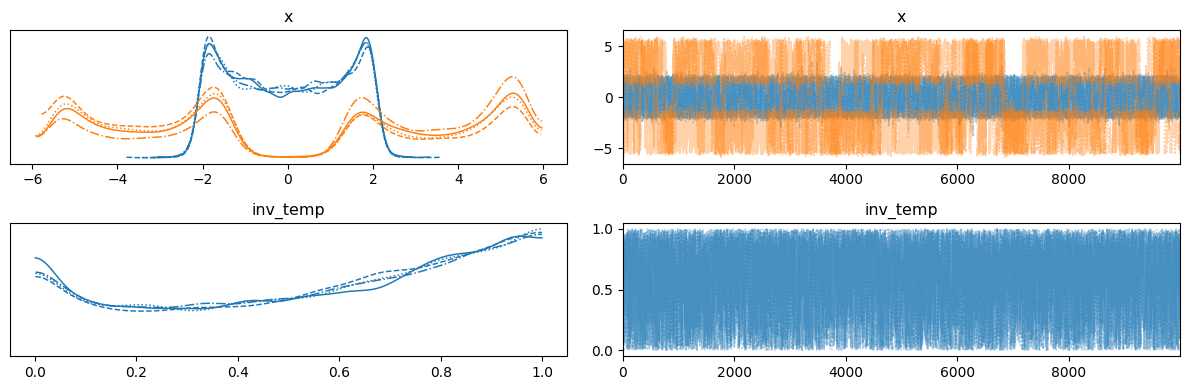

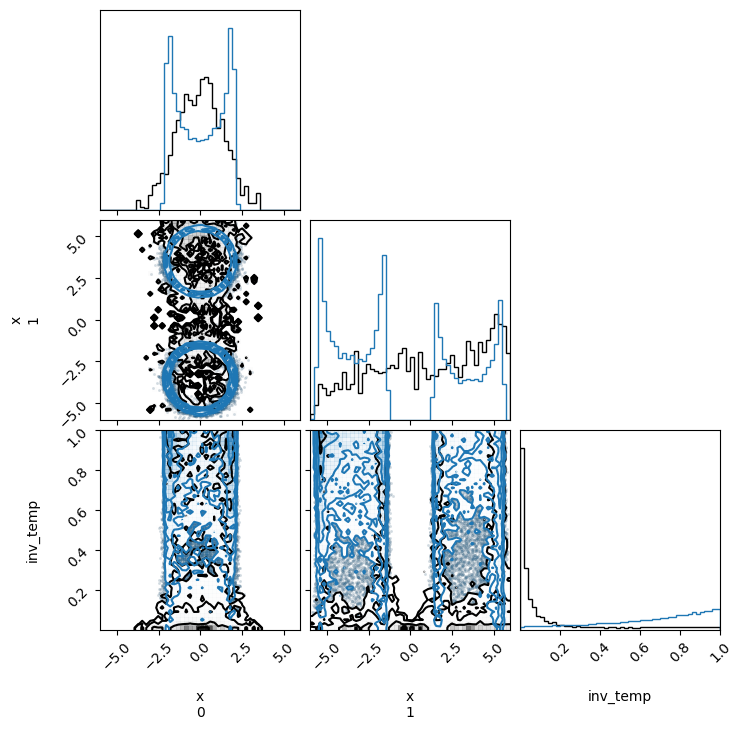

In [25]:
cthmc, neg_elbo, rng_key = iterate_cthmc(cthmc, neg_elbo, rng_key)
inf_cthmc = standard_plots(cthmc)

A far more even distribution in `inv_temp` and quite accurate evidence!  The above cell can be run again to step the system forward more iterations.

## What if the guide is not that great

Before we picked the most evenly spread of the 5 SVI solutions from the start.  But what if we picked one of the worst ones instead?

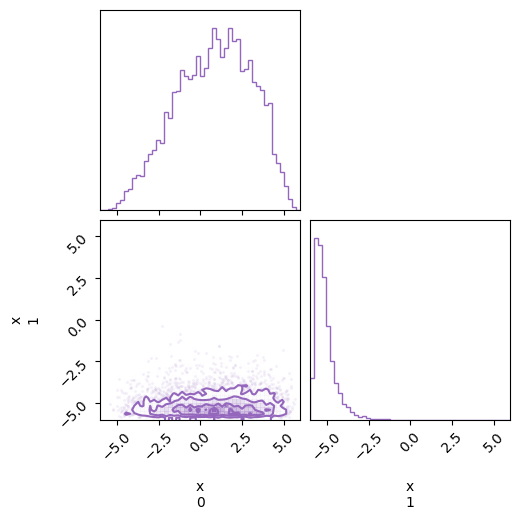

In [26]:
i=4
corner(
    multi_svi_guide_sample.isel(chain=i),
    color=f'C{i}',
    range=[(-6, 6), (-6, 6)],
    bins=50
);

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

[0 0 0 0]


/Users/coleman/anaconda3/envs/lensing/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x[0],0.090,1.344,-2.022,2.022,0.017,0.012,6574.0,16662.0,1.0
x[1],-4.228,1.320,-5.670,-1.603,0.015,0.011,7575.0,17459.0,1.0
inv_temp,0.719,0.261,0.170,1.000,0.003,0.002,9703.0,10165.0,1.0


Current log(Z) estimate: -2.3153634071350098
True log(Z) value: -1.7456541061401367


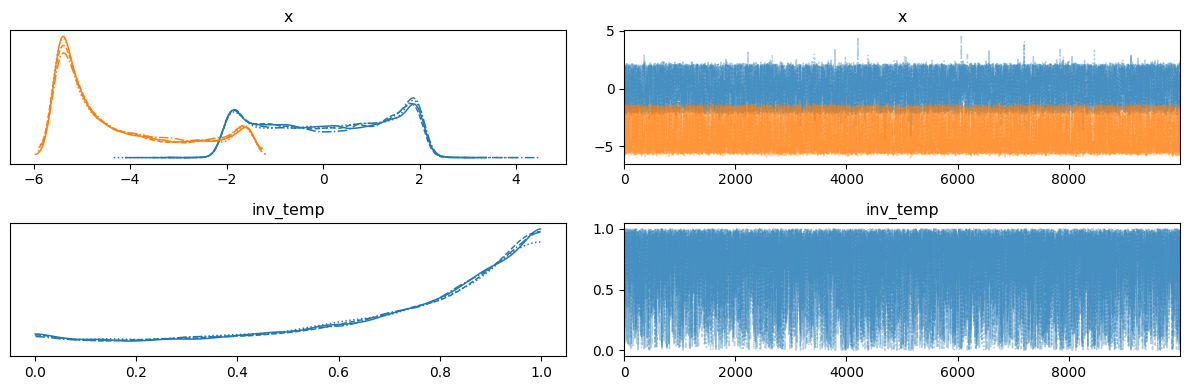

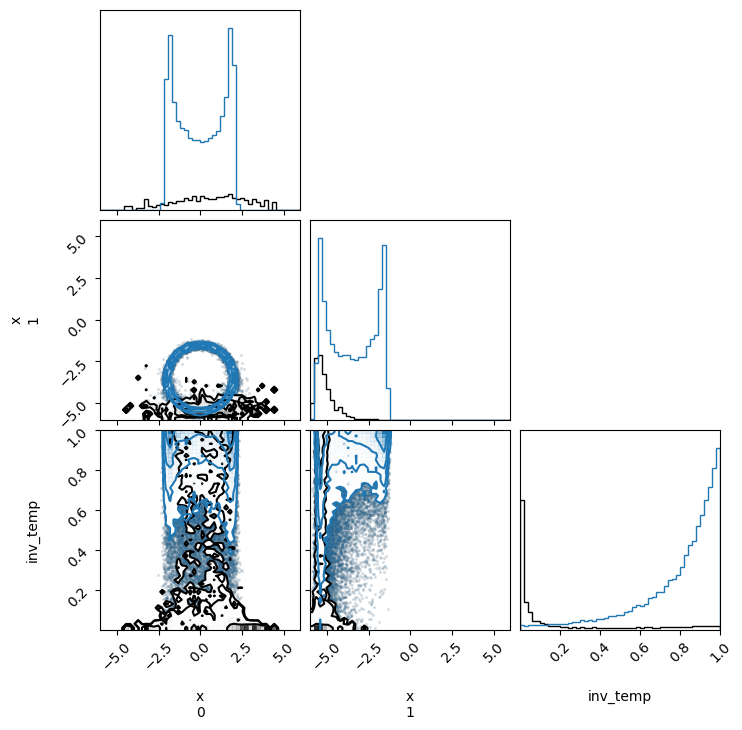

In [27]:
cthmc, neg_elbo, rng_key = first_cthmc_run(
    get_value_from_index(multi_svi_results, 4),
    rng_key
)
inf_cthmc = standard_plots(cthmc)

Not that great, we can see only one mode was found.  Let's iterate this solution and see what happens.

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

[0 0 0 0]


/Users/coleman/anaconda3/envs/lensing/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x[0],-0.003,1.387,-2.039,2.039,0.017,0.012,7187.0,19877.0,1.00
x[1],-1.913,3.279,-5.773,4.307,0.761,0.547,27.0,170.0,1.10
inv_temp,0.638,0.299,0.070,1.000,0.024,0.019,135.0,6132.0,1.02


Current log(Z) estimate: -1.5703439712524414
True log(Z) value: -1.7456541061401367


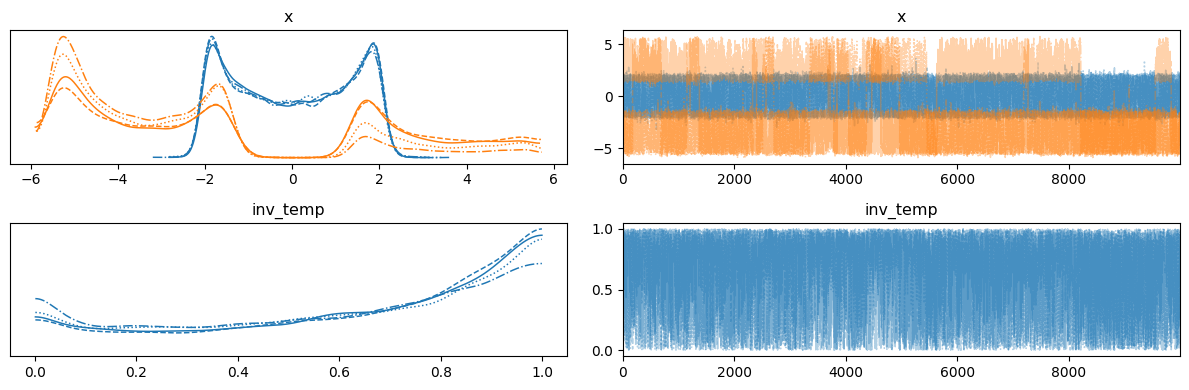

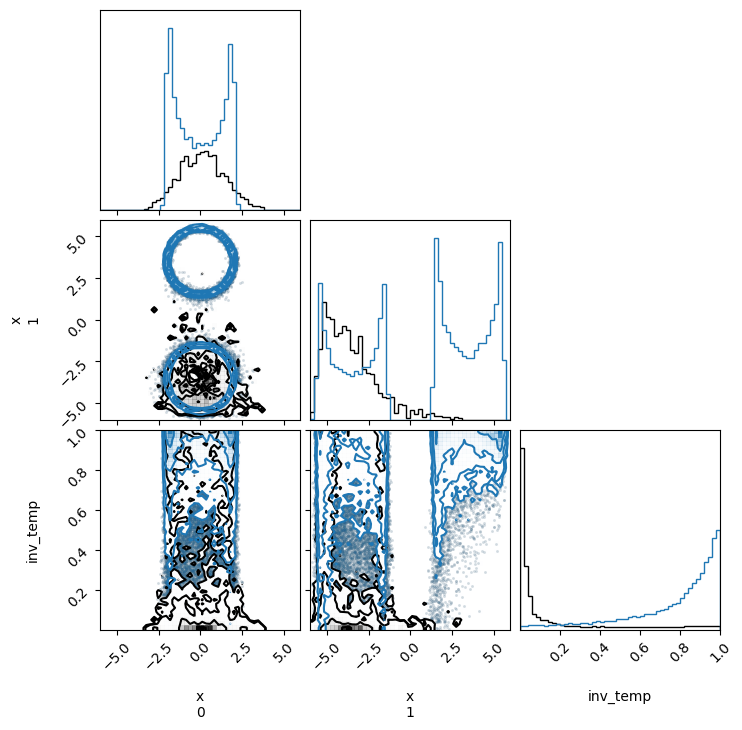

In [28]:
cthmc, neg_elbo, rng_key = iterate_cthmc(cthmc, neg_elbo, rng_key)
inf_cthmc = standard_plots(cthmc)

For this distribution the one mode is close enough to the other that the re-centered guide has helped the sampler find it.  Although the importance weights are doing quite a bit of heavy lifting at the end.  And now one more iteration to try and clean it up.

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

[0 0 0 0]


/Users/coleman/anaconda3/envs/lensing/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x[0],-0.040,1.358,-2.030,2.047,0.017,0.012,6524.0,18290.0,1.00
x[1],0.210,3.836,-5.466,5.538,0.337,0.239,183.0,2386.0,1.02
inv_temp,0.567,0.307,0.044,1.000,0.003,0.002,8622.0,9806.0,1.00


Current log(Z) estimate: -1.7726526260375977
True log(Z) value: -1.7456541061401367


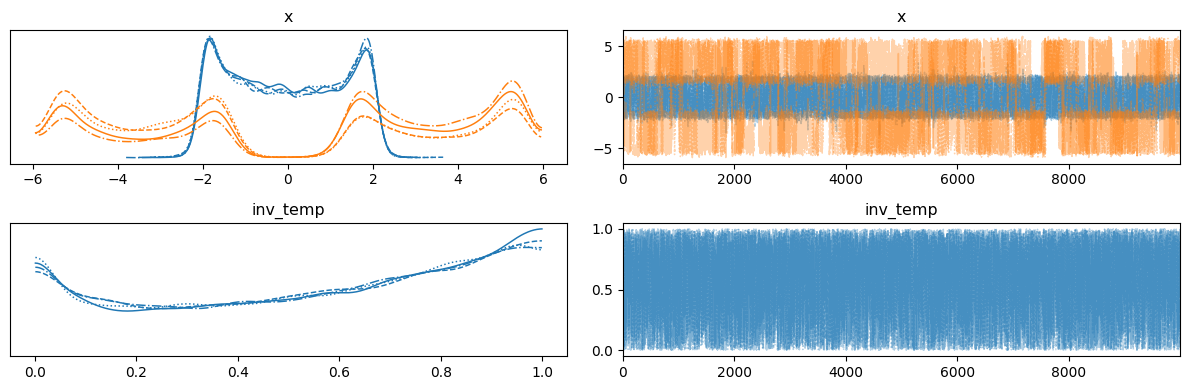

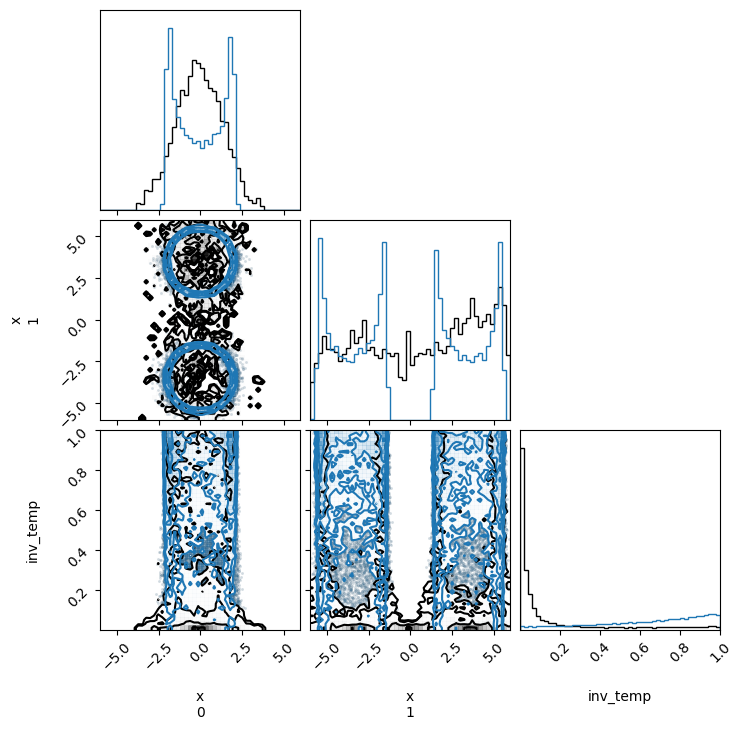

In [29]:
cthmc, neg_elbo, rng_key = iterate_cthmc(cthmc, neg_elbo, rng_key)
inf_cthmc = standard_plots(cthmc)

It took three iterations, but we were able to find a well mixed solution again!

Note: if the second mode were further away I any amount of iterations would help.